# Notebook for exploration and analysis of Fantasy Premier League data

## Abstract

Fantasy Premier League (FPL) is an online game where you choose your own team of Premier League footballers. If your players do well in real life games, you get points. It's that simple. <br>

The aim of this project is to see if current data science methods are able to predict the performance of Premier League Players to a level which would be useful for FPL team selection. <br>

The dataset for this project has been forked from Github user Vaastav (https://github.com/vaastav/Fantasy-Premier-League). The dataset spans 4 seasons: 16-17, 17-18, 18-19, 19-20. The dataset contains player performance data (points, goals, assists etc.), as well as numerous metrics related to player performance (cost, threat, creativity, etc.). <br>

Other notable projects I have come across are Github user solpaul (https://github.com/solpaul/fpl-prediction) who looked at weekly player forecasts. As well as from Github user nuebar (https://github.com/nuebar/forecasting-fantasy-football) who built a model to optimise team selection. <br>

Influenced by these projects, the hypothesis I first wanted to test was whether player performance for a whole season (FPL points total), could be predicted based on the previous season. Using a random forest regression model an *adjusted r^2* of 0.43 was achieved. <br>

I then decided to simplify the problem into predicting whether a player will improve on their previous season. This is an example of a classification problem. Using Kernel SVM an accuracy on 56% was achieved. <br>   

I then attempted to see how well a reinforcement learning model would do at choosing between the top 5 players across the 18-19 season. This was partly successful, with an upper confidence bound model choosing Mane (3rd best player) for the first half of the season, followed by DeBruyne (best player) for the second half. 

Using K-means clustering I was able to group players into 4 intuitive clusters based on their cost, and total points for a season: <br> 
(1) Low cost, low points <br>
(2) Low cost, high points <br>
(3) High cost, low points <br>
(4) High cost, high points <br>

Using TensorFlow to create a deep neural net I was then able to predict with 63% accuracy the cluster that a player would be in, based on their previous season. 

## Acknowledgements

Thank you to Github user Vaastav for providing the data used in this project.

## Import relevant libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from pathlib import Path
import os


Bad key "text.kerning_factor" on line 4 in
C:\Users\User\anaconda3\envs\py3-TF2.0\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


## Loading player data

The dataset provided by Vaastav contains data for four seasons (2016 to 2019). 

In [2]:
seasons = ['2016-17', '2017-18', '2018-19', '2019-20']

data_list = []
for s in seasons:
    data_list.append(pd.read_csv(Path.cwd() / 'data' / s / 'cleaned_players.csv')) # 2016-17 data not UTF-8, Windows cp1250, ISO-8859-1, or mbcs, listed as "ANSI", which is a vague term. Quick solution: Opened in notepad and then saved as a UTF-8 file. Longer term solution, figure out encoding using chardet or UnicodeDammit. 

data_list[0]

,first_name,second_name,goals_scored,assists,total_points,minutes,goals_conceded,creativity,influence,threat,bonus,bps,ict_index,clean_sheets,red_cards,yellow_cards,selected_by_percent
0,David,Ospina,0,0,2,143,4,0.0,28.8,0,0,18,2.9,0,0,0,0.2
1,Petr,Cech,0,0,134,3097,37,0.1,819.8,0,2,660,82.0,12,0,2,13.7
2,Laurent,Koscielny,2,1,121,2821,37,53.9,831.2,239,19,723,112.7,10,1,4,11.2
3,Per,Mertesacker,0,0,1,38,1,0.1,17.8,0,0,5,1.8,0,0,0,0.2
4,Gabriel Armando,de Abreu,0,0,45,1517,18,84.5,295.8,119,2,296,50.0,5,0,6,0.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
678,Sam,Surridge,0,0,0,0,0,0.0,0.0,0,0,0,0.0,0,0,0,0.0
679,Angel,Gomes,0,0,1,3,0,3.8,0.8,0,0,2,0.5,0,0,0,0.0
680,Kieran,O'Hara,0,0,0,0,0,0.0,0.0,0,0,0,0.0,0,0,0,0.0
681,Gerhard,Tremmel,0,0,0,0,0,0.0,0.0,0,0,0,0.0,0,0,0,0.0


### Creating new performance metrics

In [3]:
for d in data_list:
    d['mins/goal'] = d['minutes']/d['goals_scored']
    d['mins/assist'] = d['minutes']/d['assists']
    d['points/90'] = d['total_points']/d['minutes']*90

# Visualising player data for each season
### Specifically the top 5 performers each season based on:
Goals scorerd <br>
Mins/goal <br>
Assists <br>
Mins/assist <br>
Goals + assists <br>
Points  <br>
Points/90 <br>
Points/cost<br>



## Top scorers

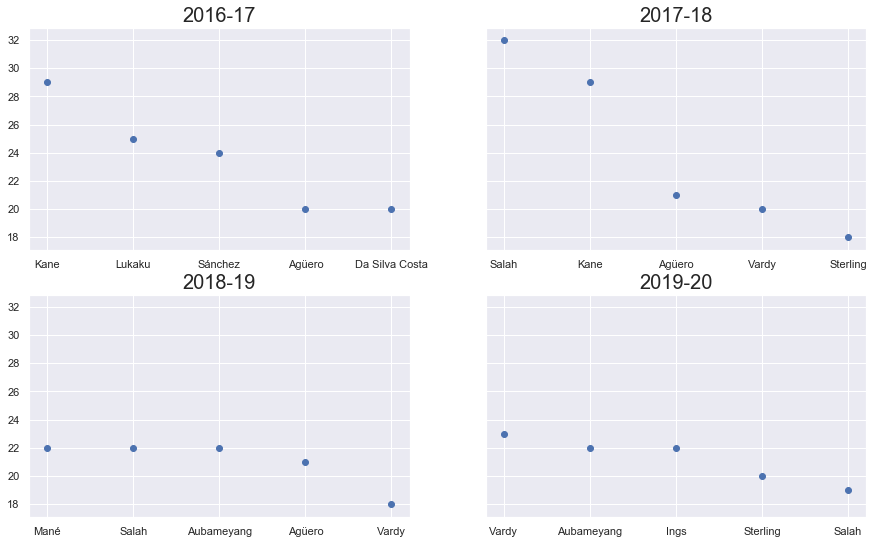

In [4]:
top_scorers = []
for d in data_list:
    top_scorers.append(d[['second_name', 'goals_scored']].sort_values(by='goals_scored', ascending=False).head(5))

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(ncols=2, nrows=2, sharey=True, figsize =(15,9))
plots = [ax1, ax2, ax3, ax4]
i = 0
for ax in plots:
    ax.scatter(top_scorers[i]['second_name'], top_scorers[i]['goals_scored'])
    ax.set_title(seasons[i], fontsize=20)
    i += 1

### Observations
I bet you didn't realise Lukaku had a 25 goal season in 16-17. <br>
Salah's first season really was incredible. <br>
The race for the golden boot has been a close run thing these past two seasons.


## Top mins per goal (for players who scored > 10 goals)

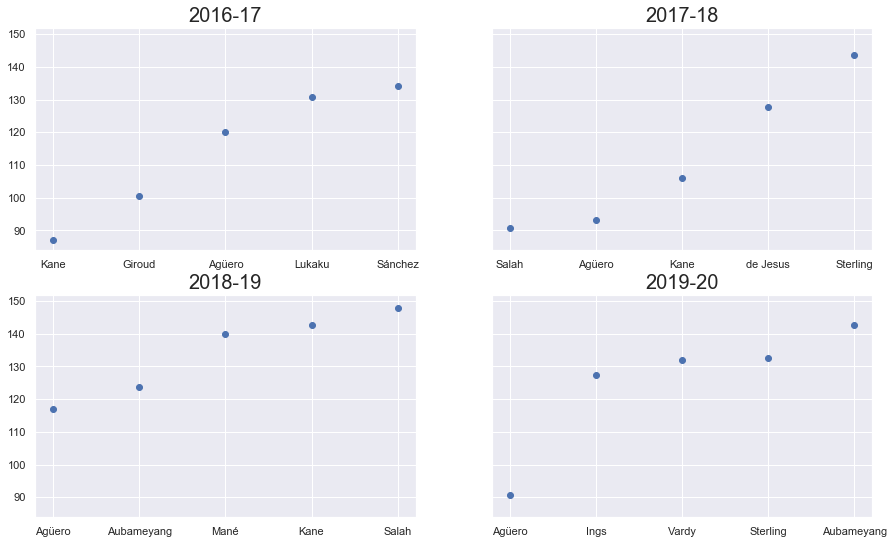

In [5]:
top_mpg = []
for d in data_list:
    d = d.loc[d['goals_scored'] > 10]
    top_mpg.append(d[['second_name', 'mins/goal']].sort_values(by='mins/goal', ascending=True).head(5))

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(ncols=2, nrows=2, sharey=True, figsize =(15,9))
plots = [ax1, ax2, ax3, ax4]
i = 0
for ax in plots:
    ax.scatter(top_mpg[i]['second_name'], top_mpg[i]['mins/goal'])
    ax.set_title(seasons[i], fontsize=20)
    i += 1

### Observations
Kane was world class back in 16-17 but has struggled to hit those lofty heights since. <br>
Giroud decided he wanted to be the best supersub in the world in 16-17. <br>
Aguero has been in the top 3 mins/goal for the past 4 seasons, yet hasn't won the golden boot in any of them. Injuries really have prevented him from posting outrageous numbers.   

## Top assisters

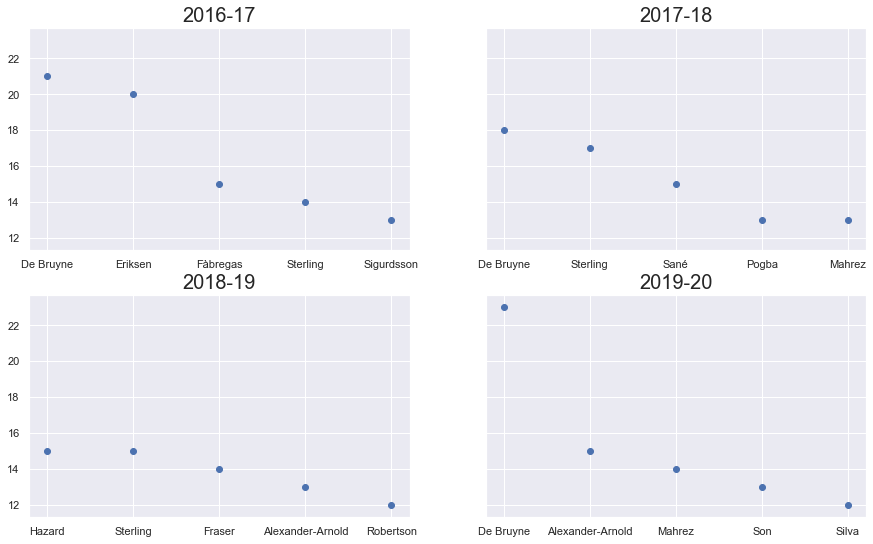

In [6]:
top_assisters = []
for d in data_list:
    top_assisters.append(d[['second_name', 'assists']].sort_values(by='assists', ascending=False).head(5))

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(ncols=2, nrows=2, sharey=True, figsize =(15,9))
plots = [ax1, ax2, ax3, ax4]
i = 0
for ax in plots:
    ax.scatter(top_assisters[i]['second_name'], top_assisters[i]['assists'])
    ax.set_title(seasons[i], fontsize=20)
    i += 1

### Observations
Kevin De Bruyne is a level above everyone else, and has been for years. And it seems like he's only getting better. <br>
Raheem Sterling's assist game has always been strong, but I guess he recently decided to start scoring the goals himself instead. <br>
Alexander-Arnold is the best fullback in world football and you can't tell me otherwise.

## Top mins per assist (for players with > 5 assists)

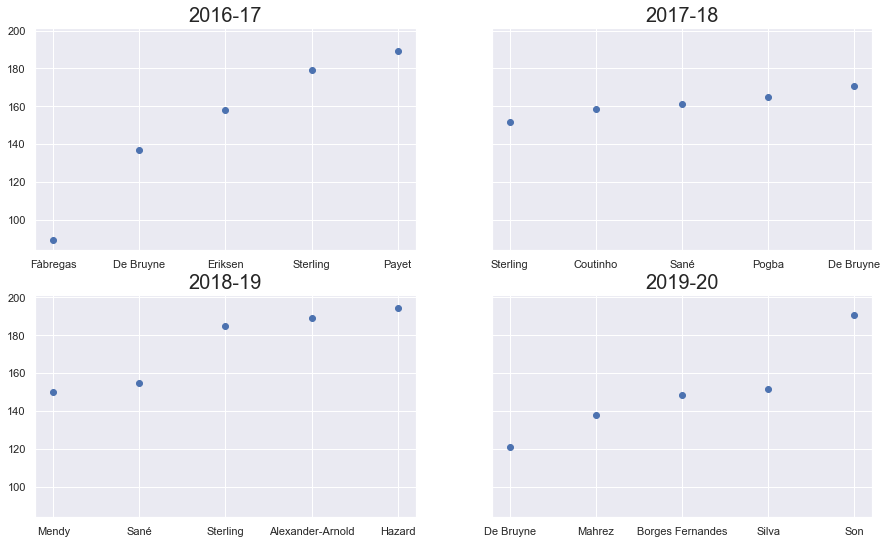

In [7]:
top_mpa = []
for d in data_list:
    d = d.loc[d['assists'] > 5]
    top_mpa.append(d[['second_name', 'mins/assist']].sort_values(by='mins/assist', ascending=True).head(5))

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(ncols=2, nrows=2, sharey=True, figsize =(15,9))
plots = [ax1, ax2, ax3, ax4]
i = 0
for ax in plots:
    ax.scatter(top_mpa[i]['second_name'], top_mpa[i]['mins/assist'])
    ax.set_title(seasons[i], fontsize=20)
    i += 1

### Observations
Fabregas 2016, at the twighlight end of his career, still has the best mins/assist of anyone (with > 5 assists in a season) in the past 4 years. <br>
Benjamin Mendy was initially justifying his signing fee, but injuries seem to have prevented him from hitting his Monaco heights.  
Leroy Sane was shaping up to have a monster season in 2019-20, but his season long injury meant we never got to find out. <br>


## Goals + assists

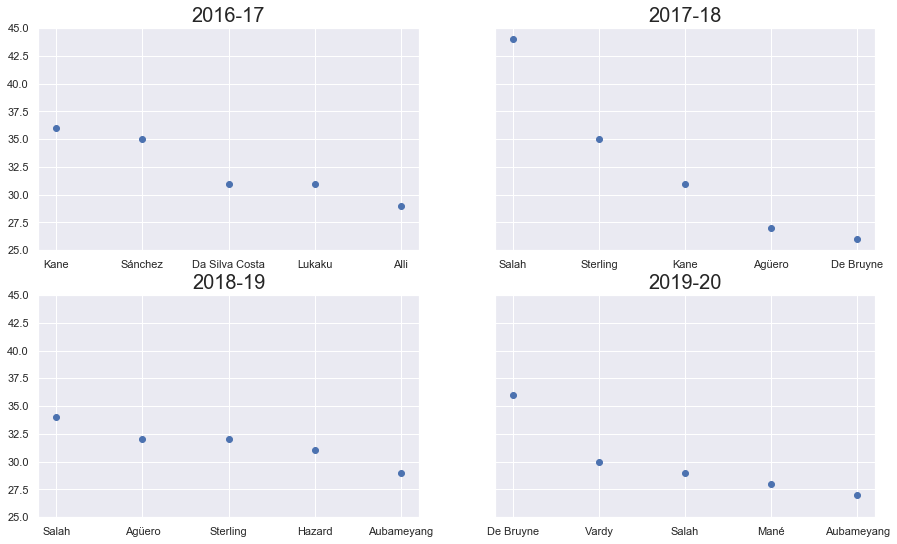

In [8]:
top_g_plus_a = []
for d in data_list:
    d['g+a'] = d['goals_scored'] + d['assists']
    top_g_plus_a.append(d[['second_name', 'g+a']].sort_values(by='g+a', ascending=False).head(5))

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(ncols=2, nrows=2, sharey=True, figsize =(15,9))
plots = [ax1, ax2, ax3, ax4]
i = 0
for ax in plots:
    ax.scatter(top_g_plus_a[i]['second_name'], top_g_plus_a[i]['g+a'])
    ax.set_title(seasons[i], fontsize=20)
    i += 1

### Observations
Deli Alli's 2016-17 season was world class, but sadly it looks like he's at risk of not fulfilling that potential. <br>
Salah 2017-18 though was out of this world, the only player that comes to mind is Suarez 2013-14 (31 goals, 12 assists). <br>
Kevin De Bruyne and Deli Alli, are the only two players in any of the top 5s who aren't forwards or wingers. De Bruyne appers twice (17-18 and 19-20), and his 2019-20 contribution is the second highest (36, joint with Kane 2016-17) of the past 4 years. 

## Total points

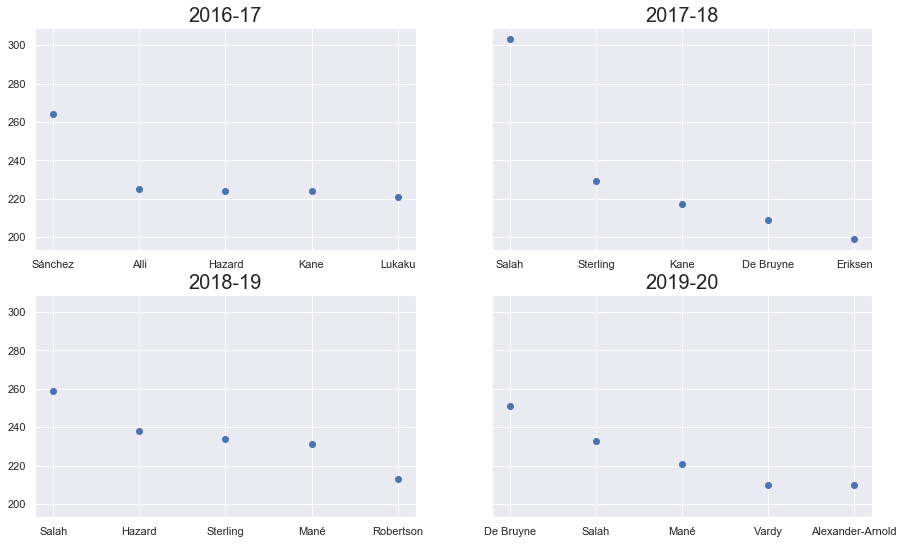

In [9]:
top_points = []
for d in data_list:
    top_points.append(d[['second_name', 'total_points']].sort_values(by='total_points', ascending=False).head(5))

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(ncols=2, nrows=2, sharey=True, figsize =(15,9))
plots = [ax1, ax2, ax3, ax4]
i = 0
for ax in plots:
    ax.scatter(top_points[i]['second_name'], top_points[i]['total_points'])
    ax.set_title(seasons[i], fontsize=20)
    i += 1

### Observations
In 16-17, 17-18, and 19-20, 4 out of the 5 players are the same players as in the top 5 goals plus assists for that season. In 18-19, 3 out of the 5 players are the same as the goals plus assist top 5. After pointing out again that Salah 17-18 was ridiculous. I'll know quickly name the players that weren't in the top 5 goals plus assists: <br>

Hazard 16-17 (over Diego Costa) <br>
Eriksen 17-18 (over Aguero) <br>
Mane 18-19 (over Augero) <br>
Robertson 18-19 (over Aubameyang) <br>
Alexander-Arnold 19-20 (over Aubameyang) <br>

## Points per 90 minutes played (for players with > 500 minutes)

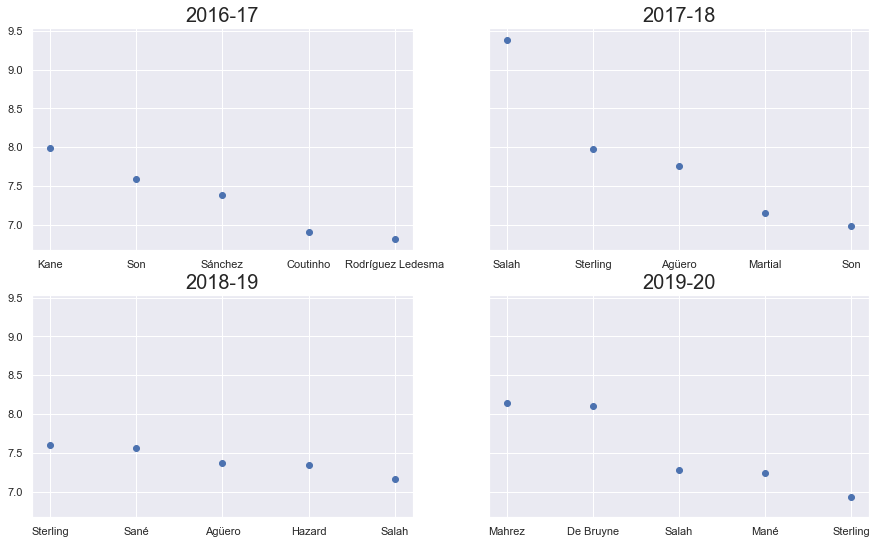

In [10]:
top_pp90 = []
for d in data_list:
    d = d.loc[d['minutes'] > 1500] # almost half the season played
    top_pp90.append(d[['second_name', 'points/90']].sort_values(by='points/90', ascending=False).head(5))

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(ncols=2, nrows=2, sharey=True, figsize =(15,9))
plots = [ax1, ax2, ax3, ax4]
i = 0
for ax in plots:
    ax.scatter(top_pp90[i]['second_name'], top_pp90[i]['points/90'])
    ax.set_title(seasons[i], fontsize=20)
    i += 1

### Observations

Son and Aguero appear twice. 
Sterling and Salah 3 times.

This is probably the most variable season to season top 5 metric so far.

Obligatory 17-18 Salah was unreal.


## Points per cost (at the end of the season). Who was the best FPL bargain in the past 3 seasons?

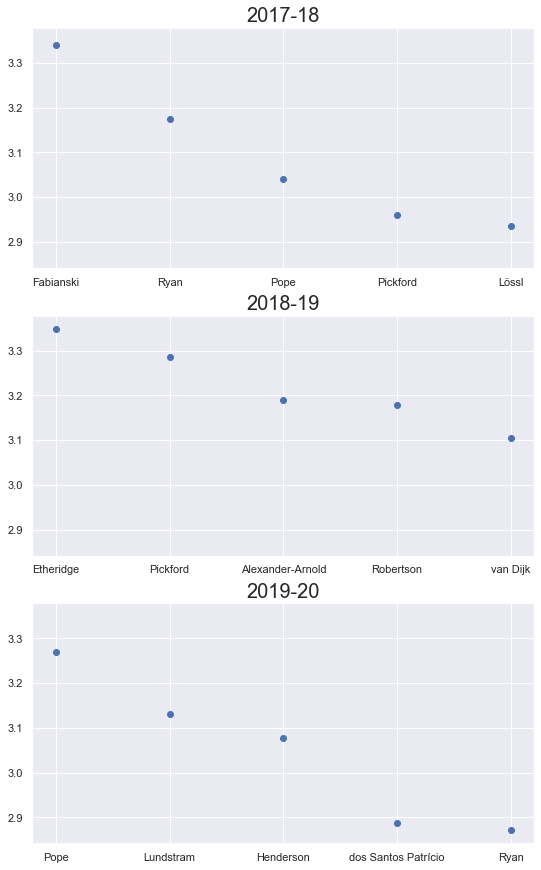

In [11]:
top_ppc = []
for d in data_list[1:]: # no data for 2016-17
    d['points/cost'] = d['total_points']/d['now_cost']
    top_ppc.append(d[['second_name', 'points/cost']].sort_values(by='points/cost', ascending=False).head(5))

f, (ax1, ax2, ax3) = plt.subplots(ncols=1, nrows=3, sharey=True, figsize =(9,15))
plots = [ax1, ax2, ax3]
i = 0
for ax in plots:
    ax.scatter(top_ppc[i]['second_name'], top_ppc[i]['points/cost'])
    ax.set_title(seasons[i+1], fontsize=20)
    i += 1

### Observations
Now this top 5 is slightly different. First off, there was no cost data for 16-17 so there are only 3 seasons. Second, all the players are goalkeepers apart from: <br>

Alexander-Arnold, Robertson, and Van Dijk (2018-19). This shows Liverpool defenders were undervalued/outperformed expectations in 2018-19. <br> 
Lundstram (2019-20), who of course was listed on FPL as a defender but played in central midfield for Sheffield United. 

Pope, Pickford, and Ryan all appear twice. 

The conclusion here is clear, give Popey the number one shirt for England. 

# Data processing
## Extracting historical data about players

In [12]:
player_names = os.listdir(Path.cwd() / 'data' / '2019-20' / 'players')
player = pd.read_csv(Path.cwd() / 'data' / '2019-20' / 'players' / 'Sergio_Agüero_210' / 'history.csv')

names = []
seasons = []
points_18_19 = []
cost_18_19 = []

a = np.empty((1,len(player.columns)))
a[:] = np.NaN
NaN_df = pd.DataFrame(a, columns=[player.columns])

# can't seem to create empty data frame so have created with arbitrary first line to remove later

player_data = pd.DataFrame(player.loc[player.season_name=='2017/18'])
for name in player_names:
    if os.path.isfile(Path.cwd() / 'data' / '2019-20' / 'players' / name / 'history.csv') == True:
        df = pd.read_csv(Path.cwd() / 'data' / '2019-20' / 'players' / name / 'history.csv')
        if df['season_name'].str.contains('2018/19').any() and df['season_name'].str.contains('2017/18').any():
            names.append(name)
            seasons.append(len(df))
            points_18_19.append(df.loc[df.season_name=='2018/19', 'total_points'].item())
            cost_18_19.append(df.loc[df.season_name=='2018/19', 'start_cost'].item())
            player_data = player_data.append(df.loc[df.season_name=='2017/18'], ignore_index=True)
            
player_data = player_data.iloc[1:]
player_data['name'] = names
player_data['cost_18_19'] = cost_18_19
player_data['points_18_19'] = points_18_19
#print(len(player_data), len(names), len(cost_18_19), len(points_18_19))
player_data

,assists,bonus,bps,clean_sheets,creativity,element_code,end_cost,goals_conceded,goals_scored,ict_index,...,red_cards,saves,season_name,start_cost,threat,total_points,yellow_cards,name,cost_18_19,points_18_19
1,7,10,613,10,562.7,55459,49,60,1,145.0,...,0,0,2017/18,50,193.0,118,7,Aaron_Cresswell_376,55,34
2,4,0,204,6,203.2,17349,54,30,0,73.3,...,0,0,2017/18,55,297.0,65,2,Aaron_Lennon_430,50,41
3,3,8,576,10,848.8,74471,52,52,4,195.2,...,0,0,2017/18,55,350.0,113,4,Aaron_Mooy_516,55,76
4,0,0,116,2,60.0,214590,45,10,0,26.8,...,0,0,2017/18,45,2.0,15,1,Aaron_Wan-Bissaka_122,40,120
5,4,16,679,9,595.8,121599,52,63,7,199.7,...,0,0,2017/18,50,537.0,136,10,Abdoulaye_Doucouré_368,60,124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,8,13,522,9,891.5,47431,70,19,6,224.5,...,0,0,2017/18,70,715.0,130,1,Willian_Borges Da Silva_113,75,108
318,0,0,54,1,0.0,20310,48,4,0,5.5,...,0,7,2017/18,50,0.0,11,0,Willy_Caballero_112,50,13
319,3,5,190,4,267.0,108413,46,16,2,64.3,...,0,0,2017/18,50,136.0,53,0,Will_Hughes_370,50,87
320,0,3,264,5,48.8,48717,48,27,0,43.6,...,0,0,2017/18,50,64.0,42,5,Winston_Reid_383,45,0


In [13]:
player_data.describe()

,assists,bonus,bps,clean_sheets,creativity,element_code,end_cost,goals_conceded,goals_scored,ict_index,...,penalties_missed,penalties_saved,red_cards,saves,start_cost,threat,total_points,yellow_cards,cost_18_19,points_18_19
count,321.000000,321.000000,321.000000,321.000000,321.000000,321.000000,321.000000,321.000000,321.000000,321.000000,...,321.000000,321.000000,321.000000,321.000000,321.000000,321.000000,321.000000,321.000000,321.000000,321.000000
mean,2.218069,5.806854,331.492212,5.906542,257.835202,92331.224299,54.520249,24.043614,2.395639,93.860125,...,0.056075,0.059190,0.090343,5.398754,55.996885,278.598131,72.177570,2.485981,55.264798,67.813084
std,3.080551,6.375741,219.770777,4.433959,288.422080,60393.988653,14.961003,16.297947,4.180593,78.732428,...,0.268041,0.315611,0.308120,21.604756,14.440719,349.975049,50.960244,2.412330,14.356237,53.304631
min,0.000000,0.000000,-1.000000,0.000000,0.000000,6744.000000,40.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,40.000000,0.000000,0.000000,0.000000,40.000000,0.000000
25%,0.000000,0.000000,171.000000,2.000000,32.100000,47431.000000,45.000000,11.000000,0.000000,33.100000,...,0.000000,0.000000,0.000000,0.000000,45.000000,26.000000,32.000000,0.000000,45.000000,24.000000
50%,1.000000,4.000000,335.000000,6.000000,163.500000,77794.000000,49.000000,25.000000,1.000000,83.400000,...,0.000000,0.000000,0.000000,0.000000,50.000000,145.000000,72.000000,2.000000,50.000000,60.000000
75%,3.000000,9.000000,491.000000,9.000000,377.200000,122798.000000,58.000000,34.000000,3.000000,127.100000,...,0.000000,0.000000,0.000000,0.000000,60.000000,404.000000,101.000000,4.000000,60.000000,98.000000
max,18.000000,31.000000,913.000000,19.000000,1744.200000,433154.000000,131.000000,63.000000,32.000000,454.400000,...,2.000000,3.000000,2.000000,137.000000,125.000000,2355.000000,303.000000,11.000000,130.000000,259.000000


In [14]:
player_data_ordered = player_data[['name', 'assists', 'bonus', 'bps', 'clean_sheets', 'creativity', 'end_cost',
       'goals_conceded', 'goals_scored', 'ict_index', 'influence', 'minutes',
       'own_goals', 'penalties_missed', 'penalties_saved', 'red_cards',
       'saves', 'start_cost', 'threat', 'total_points',
       'yellow_cards', 'cost_18_19', 'points_18_19']]
player_data_ordered

,name,assists,bonus,bps,clean_sheets,creativity,end_cost,goals_conceded,goals_scored,ict_index,...,penalties_missed,penalties_saved,red_cards,saves,start_cost,threat,total_points,yellow_cards,cost_18_19,points_18_19
1,Aaron_Cresswell_376,7,10,613,10,562.7,49,60,1,145.0,...,0,0,0,0,50,193.0,118,7,55,34
2,Aaron_Lennon_430,4,0,204,6,203.2,54,30,0,73.3,...,0,0,0,0,55,297.0,65,2,50,41
3,Aaron_Mooy_516,3,8,576,10,848.8,52,52,4,195.2,...,0,0,0,0,55,350.0,113,4,55,76
4,Aaron_Wan-Bissaka_122,0,0,116,2,60.0,45,10,0,26.8,...,0,0,0,0,45,2.0,15,1,40,120
5,Abdoulaye_Doucouré_368,4,16,679,9,595.8,52,63,7,199.7,...,0,0,0,0,50,537.0,136,10,60,124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,Willian_Borges Da Silva_113,8,13,522,9,891.5,70,19,6,224.5,...,0,0,0,0,70,715.0,130,1,75,108
318,Willy_Caballero_112,0,0,54,1,0.0,48,4,0,5.5,...,0,0,0,7,50,0.0,11,0,50,13
319,Will_Hughes_370,3,5,190,4,267.0,46,16,2,64.3,...,0,0,0,0,50,136.0,53,0,50,87
320,Winston_Reid_383,0,3,264,5,48.8,48,27,0,43.6,...,0,0,0,0,50,64.0,42,5,45,0


In [15]:
player_data_ordered.to_csv('outputs/historical_player_data.csv', index=False)

## Viewing distributions of historical player data

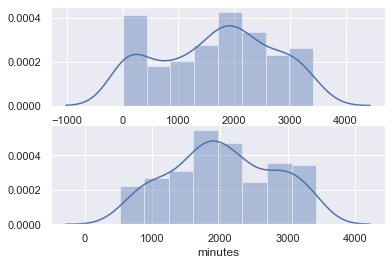

In [16]:
plt.subplot(211)
sns.distplot(player_data_ordered['minutes'])
plt.subplot(212)
sns.distplot(player_data_ordered.loc[player_data_ordered.minutes > 500, 'minutes'])

Justification to only analyse players with > 25 points & > 500 minutes in 17_18?

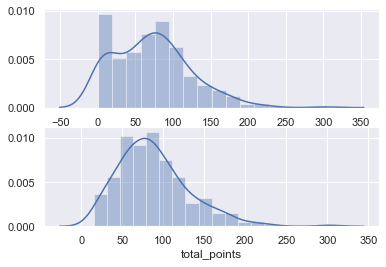

In [17]:
plt.subplot(211)
sns.distplot(player_data_ordered['total_points'])
plt.subplot(212)
sns.distplot(player_data_ordered.loc[player_data_ordered.minutes > 500, 'total_points'])

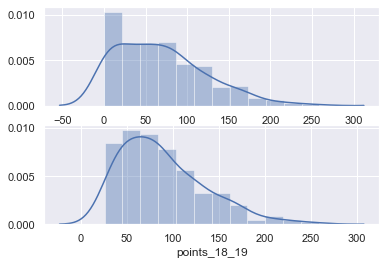

In [18]:
plt.subplot(211)
sns.distplot(player_data_ordered['points_18_19'])
plt.subplot(212)
sns.distplot(player_data_ordered.loc[player_data_ordered.points_18_19 > 25, 'points_18_19'])

### Restrict data to players with > 500 minutes in 17/18 (?), and > 25 points in 18/19

In [19]:
player_data_restrict = player_data_ordered[(player_data_ordered.minutes > 500) & (player_data.points_18_19 > 25)]
player_data_restrict[['minutes', 'total_points', 'points_18_19']].describe()

,minutes,total_points,points_18_19
count,215.000000,215.000000,215.000000
mean,2156.302326,94.734884,91.855814
std,753.257212,43.735285,46.318308
min,530.000000,15.000000,26.000000
25%,1663.000000,65.000000,56.000000
50%,2169.000000,87.000000,83.000000
75%,2817.000000,116.000000,119.000000
max,3420.000000,303.000000,259.000000


## Multicolinearity

'ict_index' is calculated from 'threat', 'creativity', and 'influence', explains high VIF

In [20]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
variables = player_data_ordered.iloc[:,1:-1]
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
vif["features"] = variables.columns
vif

,VIF,features
0,10.614242,assists
1,11.056960,bonus
2,164.472703,bps
3,37.353325,clean_sheets
4,24455.134968,creativity
5,887.352711,end_cost
6,53.192507,goals_conceded
7,22.039562,goals_scored
8,244227.282585,ict_index
9,40084.593495,influence


# Data analysis#

regression <br>
clustering <br>
reinforcement learning <br>
deep learning using TensorFlow <br>

## Regression analysis
### Declare features and standardize

In [21]:
inputs = player_data_restrict.iloc[:, 1:-1]
targets = player_data_restrict['points_18_19']


from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(inputs)
inputs_scaled = scaler.transform(inputs)

In [22]:
inputs

,assists,bonus,bps,clean_sheets,creativity,end_cost,goals_conceded,goals_scored,ict_index,influence,...,own_goals,penalties_missed,penalties_saved,red_cards,saves,start_cost,threat,total_points,yellow_cards,cost_18_19
1,7,10,613,10,562.7,49,60,1,145.0,690.2,...,0,0,0,0,0,50,193.0,118,7,55
2,4,0,204,6,203.2,54,30,0,73.3,232.2,...,0,0,0,0,0,55,297.0,65,2,50
3,3,8,576,10,848.8,52,52,4,195.2,753.2,...,0,0,0,0,0,55,350.0,113,4,55
4,0,0,116,2,60.0,45,10,0,26.8,207.2,...,0,0,0,0,0,45,2.0,15,1,40
5,4,16,679,9,595.8,52,63,7,199.7,859.0,...,0,0,0,0,0,50,537.0,136,10,60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,4,4,449,9,230.7,49,45,0,117.2,640.4,...,0,0,0,2,0,50,299.0,78,6,50
316,7,8,404,10,716.9,71,31,9,251.0,668.0,...,0,0,0,0,0,70,1125.0,136,5,70
317,8,13,522,9,891.5,70,19,6,224.5,640.0,...,0,0,0,0,0,70,715.0,130,1,75
319,3,5,190,4,267.0,46,16,2,64.3,238.6,...,0,0,0,0,0,50,136.0,53,0,50


## Split the data

In [23]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(inputs_scaled, targets, test_size=0.2, random_state=42)

# Linear Regression using sklearn

In [24]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
reg.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

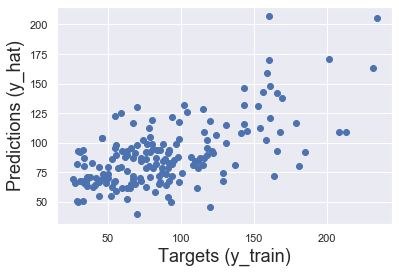

In [25]:
y_hat = reg.predict(x_train)

plt.scatter(y_train, y_hat)
plt.xlabel('Targets (y_train)', size=18)
plt.ylabel('Predictions (y_hat)', size=18)
plt.show()

Text(0.5, 1.0, 'Residuals PDF')

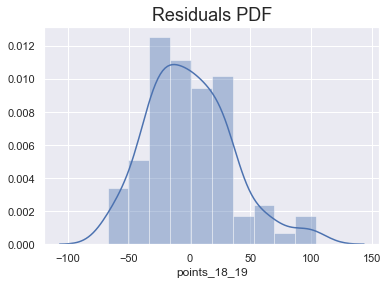

In [26]:
sns.distplot(y_train - y_hat)
plt.title('Residuals PDF', size=18)

In [27]:
r2 = reg.score(x_train, y_train)
r2

0.39209802991296094

In [28]:
n = inputs.shape[0]
p = inputs.shape[1]

adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
adjusted_r2 

0.3259532559656666

## Manually check the accuracy

e.g. how many predictions are within 10% of the targets? <br>

is the absolute difference between y_hat and y less than 10% of y?

In [29]:
model_outputs = reg.predict(x_train)
threshold = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
acc = []
for t in threshold:
    acc.append((np.sum(abs(model_outputs-y_train) <= y_train * t) / model_outputs.shape[0]).round(2))
    
acc_df = pd.DataFrame(threshold, columns=['threshold'])
acc_df['accuracy'] = acc
acc_df

,threshold,accuracy
0,0.05,0.12
1,0.10,0.19
2,0.20,0.38
3,0.30,0.58
4,0.40,0.65
5,0.50,0.76


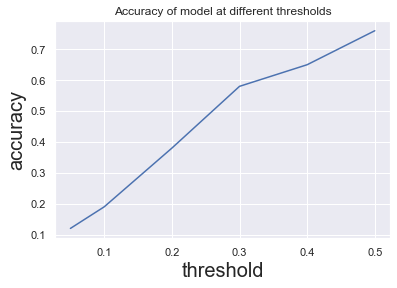

In [30]:
plt.plot(acc_df['threshold'], acc_df['accuracy'])
plt.title('Accuracy of model at different thresholds')
plt.xlabel('threshold', fontsize=20)
plt.ylabel('accuracy', fontsize=20)
plt.show()

### Creating a summary table

In [31]:
reg_summary = pd.DataFrame(inputs.columns.values, columns=['Features'])
reg_summary['Weights'] = reg.coef_
reg_summary = reg_summary.append({'Features':'bias','Weights':reg.intercept_}, ignore_index=True)
reg_summary.sort_values('Weights', ascending=False)

,Features,Weights
8,ict_index,321.743452
21,bias,91.295640
20,cost_18_19,45.906306
18,total_points,17.945379
3,clean_sheets,9.639033
6,goals_conceded,8.238572
13,penalties_saved,5.190817
14,red_cards,2.726635
15,saves,1.440047
2,bps,1.418977


## Testing

In [32]:
y_hat_test = reg.predict(x_test)

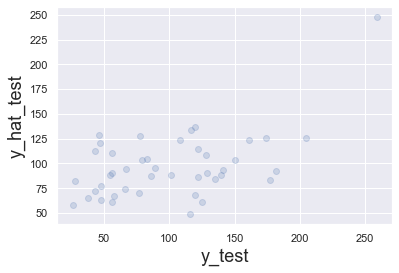

In [33]:
plt.scatter(y_test, y_hat_test, alpha=0.2)
plt.xlabel('y_test', size=18)
plt.ylabel('y_hat_test', size=18)
plt.show()

In [34]:
table = pd.DataFrame(y_test)
table['y_hat'] = y_hat_test
table['delta'] = table.iloc[:,0] - table.iloc[:,1]
table['perc_diff'] = abs(table['delta'] / table['points_18_19'] * 100)
table['name'] = player_data_restrict['name']
table['total_points'] = player_data_restrict['total_points']
table.drop(table[table.points_18_19 == 0].index, inplace=True)
table = table[['name', 'total_points', 'points_18_19', 'y_hat', 'delta', 'perc_diff']]
table.sort_values(by='points_18_19', ascending=False)

,name,total_points,points_18_19,y_hat,delta,perc_diff
229,Mohamed_Salah_191,303,259,247.970998,11.029002,4.258302
258,Pierre-Emerick_Aubameyang_11,87,205,125.954993,79.045007,38.558540
123,Gylfi_Sigurdsson_151,96,182,92.286982,89.713018,49.292867
35,Aymeric_Laporte_202,35,177,83.746841,93.253159,52.685400
151,Jamie_Vardy_166,183,174,125.723242,48.276758,27.745263
205,Marcos_Alonso_103,165,161,123.980954,37.019046,22.993196
190,Kyle_Walker_203,138,150,103.454250,46.545750,31.030500
174,Joshua_King_68,110,141,93.481941,47.518059,33.700751
247,Patrick_van Aanholt_123,95,140,88.561806,51.438194,36.741567
23,Andros_Townsend_135,121,135,84.706381,50.293619,37.254533


In [35]:
table.describe()

,total_points,points_18_19,y_hat,delta,perc_diff
count,43.000000,43.000000,43.000000,43.000000,43.000000
mean,99.627907,100.116279,97.315407,2.800872,49.025988
std,50.020007,52.514492,33.119876,45.052086,47.619522
min,21.000000,26.000000,48.659955,-82.622469,1.524613
25%,67.500000,56.000000,75.771792,-28.299312,15.047074
50%,96.000000,89.000000,90.641355,-6.507602,33.700751
75%,123.000000,128.500000,113.533505,42.452198,60.590372
max,303.000000,259.000000,247.970998,93.253159,192.345768


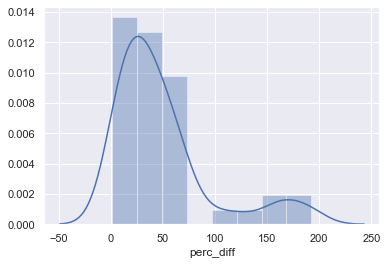

In [36]:
sns.distplot(table['perc_diff'])

## Linear regression discussion

A linear regression is a good start, but the accuracy is too low to be of use in FPL. There are likely non-linearities within the data, lets see what level of accuracy can be achieved using non-linear regressors. 

# Non-linear regression - Random Forest

In [37]:
dataset = pd.read_csv('outputs/historical_player_data.csv')
X = dataset.iloc[:, 1:-1].values
y = dataset.iloc[:, -1].values

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [38]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 10, random_state = 0)
regressor.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [39]:
y_pred = regressor.predict(X_test)
np.set_printoptions(precision=2)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

[[ 91.7  120.  ]
 [ 60.    90.  ]
 [ 65.8    2.  ]
 [ 23.7   93.  ]
 [ 91.    34.  ]
 [ 25.4    0.  ]
 [ 69.2   44.  ]
 [172.6  259.  ]
 [ 35.8   76.  ]
 [ 93.7   73.  ]
 [ 30.2    9.  ]
 [ 31.1    0.  ]
 [161.   160.  ]
 [ 97.6  108.  ]
 [114.4   67.  ]
 [106.4   56.  ]
 [ 90.7  182.  ]
 [ 52.3   24.  ]
 [ 25.29   0.  ]
 [124.3  122.  ]
 [ 19.4    0.  ]
 [ 72.8   83.  ]
 [ 20.94  42.  ]
 [ 64.1   94.  ]
 [ 78.7   39.  ]
 [ 23.9   28.  ]
 [168.4  115.  ]
 [ 39.7   34.  ]
 [ 52.6   70.  ]
 [ 52.    76.  ]
 [ 36.7   25.  ]
 [ 81.   135.  ]
 [123.6   67.  ]
 [ 50.    83.  ]
 [ 55.2   55.  ]
 [117.3   78.  ]
 [112.8   47.  ]
 [ 88.4   79.  ]
 [113.3  158.  ]
 [111.   121.  ]
 [ 68.8   30.  ]
 [ 24.5    0.  ]
 [ 52.1   36.  ]
 [ 91.8  113.  ]
 [ 88.7  116.  ]
 [ 66.5   15.  ]
 [ 41.1   93.  ]
 [167.1  160.  ]
 [ 49.6   86.  ]
 [ 59.   164.  ]
 [ 78.1   80.  ]
 [ 37.65   1.  ]
 [153.4  102.  ]
 [115.8   44.  ]
 [ 79.6   78.  ]
 [ 37.65  35.  ]
 [ 49.5   33.  ]
 [  8.81  17.  ]
 [ 28.9   67. 

In [40]:
from sklearn.metrics import r2_score
r2_score(y_test, y_pred)

0.42946811425246345

# Non-linear regression - XGBOOSt

In [41]:
from xgboost import XGBRegressor
regressor = XGBRegressor()
regressor.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

## Evaluating the Model Performance

In [42]:
y_pred = regressor.predict(X_test)
np.set_printoptions(suppress=True)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

[[ 81.26 120.  ]
 [ 46.33  90.  ]
 [111.61   2.  ]
 [ 16.81  93.  ]
 [ 83.67  34.  ]
 [ 30.56   0.  ]
 [ 52.97  44.  ]
 [181.08 259.  ]
 [ 30.74  76.  ]
 [ 77.96  73.  ]
 [ 30.98   9.  ]
 [ 39.61   0.  ]
 [183.61 160.  ]
 [122.72 108.  ]
 [ 89.27  67.  ]
 [110.    56.  ]
 [ 89.04 182.  ]
 [ 72.62  24.  ]
 [ 28.99   0.  ]
 [150.53 122.  ]
 [ 23.18   0.  ]
 [ 53.54  83.  ]
 [ 18.12  42.  ]
 [ 60.35  94.  ]
 [ 84.64  39.  ]
 [ 14.32  28.  ]
 [176.15 115.  ]
 [ 48.44  34.  ]
 [ 35.06  70.  ]
 [ 42.48  76.  ]
 [  6.96  25.  ]
 [ 99.77 135.  ]
 [108.99  67.  ]
 [ 42.25  83.  ]
 [ 32.78  55.  ]
 [141.8   78.  ]
 [124.21  47.  ]
 [101.34  79.  ]
 [107.67 158.  ]
 [ 94.09 121.  ]
 [ 52.25  30.  ]
 [ 12.7    0.  ]
 [ 31.53  36.  ]
 [ 91.8  113.  ]
 [ 39.34 116.  ]
 [ 45.56  15.  ]
 [ 33.77  93.  ]
 [178.04 160.  ]
 [ 77.93  86.  ]
 [ 48.96 164.  ]
 [ 76.48  80.  ]
 [ 30.82   1.  ]
 [170.07 102.  ]
 [ 94.89  44.  ]
 [ 69.43  78.  ]
 [ 30.82  35.  ]
 [ 51.53  33.  ]
 [  0.16  17.  ]
 [ 49.09  67. 

In [43]:
from sklearn.metrics import r2_score
r2_score(y_test, y_pred)

0.29588079088780694

## Applying k-Fold Cross Validation

In [44]:
from sklearn.model_selection import cross_val_score
r2s = cross_val_score(estimator = regressor, X = X_train, y = y_train, cv = 10)
print("r2: {:.2f}".format(r2s.mean()))
print("Standard Deviation: {:.2f}".format(r2s.std()))

r2: 0.12
Standard Deviation: 0.33


In [45]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(estimator = regressor, X = X_train, y = y_train, cv = 10, scoring = 'neg_mean_squared_error')
print("MSE: {:.2f} ".format(scores.mean()))
print("Standard Deviation: {:.2f} ".format(scores.std()))

MSE: -2269.00 
Standard Deviation: 517.28 


## Manually checking accuracy

In [46]:
threshold = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
acc = []
for t in threshold:
    acc.append((np.sum(abs(y_pred - y_test) <= y_test * t) / y_pred.shape[0]).round(2))
acc_df = pd.DataFrame(threshold, columns=['threshold'])
acc_df['accuracy'] = acc
acc_df

,threshold,accuracy
0,0.05,0.03
1,0.10,0.06
2,0.20,0.17
3,0.30,0.28
4,0.40,0.38
5,0.50,0.49


Text(0.5, 1.0, 'Residuals PDF')

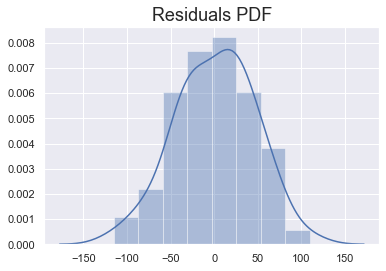

In [47]:
sns.distplot(y_pred - y_test)
plt.title('Residuals PDF', size=18)

# Classification 

Creating csv with binary column, 0 if player got performed worse than last season, 1 if performed better

In [48]:
player_data_restrict['improve'] = player_data_restrict['points_18_19'] - player_data_restrict['total_points'] 
player_data_restrict.loc[player_data_restrict.improve > 0, 'improve'] = 1
player_data_restrict.loc[player_data_restrict.improve <= 0, 'improve'] = 0
player_data_restrict.drop('points_18_19', axis=1, inplace=True)
player_data_restrict.to_csv('outputs/player_improvement.csv', index=False)
player_data_restrict

,name,assists,bonus,bps,clean_sheets,creativity,end_cost,goals_conceded,goals_scored,ict_index,...,penalties_missed,penalties_saved,red_cards,saves,start_cost,threat,total_points,yellow_cards,cost_18_19,improve
1,Aaron_Cresswell_376,7,10,613,10,562.7,49,60,1,145.0,...,0,0,0,0,50,193.0,118,7,55,0
2,Aaron_Lennon_430,4,0,204,6,203.2,54,30,0,73.3,...,0,0,0,0,55,297.0,65,2,50,0
3,Aaron_Mooy_516,3,8,576,10,848.8,52,52,4,195.2,...,0,0,0,0,55,350.0,113,4,55,0
4,Aaron_Wan-Bissaka_122,0,0,116,2,60.0,45,10,0,26.8,...,0,0,0,0,45,2.0,15,1,40,1
5,Abdoulaye_Doucouré_368,4,16,679,9,595.8,52,63,7,199.7,...,0,0,0,0,50,537.0,136,10,60,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,Wilfred_Ndidi_176,4,4,449,9,230.7,49,45,0,117.2,...,0,0,2,0,50,299.0,78,6,50,1
316,Wilfried_Zaha_133,7,8,404,10,716.9,71,31,9,251.0,...,0,0,0,0,70,1125.0,136,5,70,1
317,Willian_Borges Da Silva_113,8,13,522,9,891.5,70,19,6,224.5,...,0,0,0,0,70,715.0,130,1,75,0
319,Will_Hughes_370,3,5,190,4,267.0,46,16,2,64.3,...,0,0,0,0,50,136.0,53,0,50,1


In [49]:
## Importing the dataset
dataset = pd.read_csv('outputs/player_improvement.csv')
X = dataset.iloc[:, 1:-1].values
y = dataset.iloc[:, -1].values

## Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

## Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## Training the Kernel SVM model on the Training set
from sklearn.svm import SVC
classifier = SVC(kernel = 'rbf', random_state = 0)
classifier.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=0, shrinking=True, tol=0.001,
    verbose=False)

In [50]:
## Making the Confusion Matrix
from sklearn.metrics import confusion_matrix, accuracy_score
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

[[19  8]
 [17 10]]


0.5370370370370371

In [51]:
## Applying k-fold cross validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Accuracy: 67.61 %
Standard Deviation: 8.48 %


In [52]:
## Applying Grid Search to find the best model and the best parameters
from sklearn.model_selection import GridSearchCV
parameters = [{'C': [0.25, 0.5, 0.75, 1], 'kernel': ['linear']},
              {'C': [0.25, 0.5, 0.75, 1], 'kernel': ['rbf'], 'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}]
grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 10,
                           n_jobs = -1)
grid_search.fit(X_train, y_train)
best_accuracy = grid_search.best_score_
best_params = grid_search.best_params_
print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
print("Best Parameters:", best_params)

Best Accuracy: 70.15 %
Best Parameters: {'C': 0.75, 'gamma': 0.3, 'kernel': 'rbf'}


In [53]:
## Rebuilding the model with the best parameters
from sklearn.svm import SVC
classifier = SVC(kernel = best_params['kernel'], C = best_params['C'], random_state = 0)
classifier.fit(X_train, y_train)

SVC(C=0.75, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=0, shrinking=True, tol=0.001,
    verbose=False)

In [54]:
from sklearn.metrics import confusion_matrix, accuracy_score
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

[[19  8]
 [16 11]]


0.5555555555555556

# Reinforcement learning - upper confidence bound (UCB)

In [55]:
path = Path.cwd() / 'data' / '2019-20' / 'players'

goals = []
for player in top_points[3]['second_name'].values:
    name = '*' + player + '*' 
    df = pd.read_csv(list(path.glob(name))[0] / 'gw.csv')
    #goals.append(df['goals_scored'].values)
    goals.append(df['total_points'].values)
    
dataset = pd.DataFrame(goals).T
dataset.columns = top_points[3]['second_name'].values
dataset

,De Bruyne,Salah,Mané,Vardy,Alexander-Arnold
0,7,12,1,2,5
1,11,3,13,2,1
2,5,15,3,8,5
3,13,6,8,16,11
4,1,9,15,2,2
5,17,5,2,2,7
6,9,3,3,12,6
7,0,2,12,2,3
8,3,0,2,8,2
9,6,7,5,20,1


## Implementing upper confidence bound learning

In [56]:
import math
N = dataset.shape[0]
d = dataset.shape[1]
players_selected = []
numbers_of_selections = [0] * d
sums_of_rewards = [0] * d
total_reward = 0
for n in range(0, N):
    player = 0
    max_upper_bound = 0
    for i in range(0, d):
        if (numbers_of_selections[i] > 0):
            average_reward = sums_of_rewards[i] / numbers_of_selections[i]
            delta_i = math.sqrt(3/2 * math.log(n + 1) / numbers_of_selections[i])
            upper_bound = average_reward + delta_i
        else:
            upper_bound = 1e400
        if upper_bound > max_upper_bound:
            max_upper_bound = upper_bound
            player = i
    players_selected.append(player)
    numbers_of_selections[player] = numbers_of_selections[player] + 1
    reward = dataset.values[n, player]
    sums_of_rewards[player] = sums_of_rewards[player] + reward
    total_reward = total_reward + reward

## Visualising the results

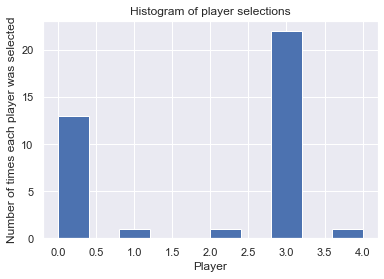

In [57]:
plt.hist(players_selected)
plt.title('Histogram of player selections')
plt.xlabel('Player')
plt.ylabel('Number of times each player was selected')
plt.show()

In [58]:
dataset.columns
for player in dataset.columns:
    print(player, sum(dataset[player]))
#print(sum(dataset.Kane)

De Bruyne 251
Salah 233
Mané 221
Vardy 210
Alexander-Arnold 210


In [59]:
players_selected

[0,
 1,
 2,
 3,
 4,
 3,
 3,
 3,
 3,
 0,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 0,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [60]:
data = dataset.copy()
for player in data.columns:
    data[player + '_cumsum'] = data[player].cumsum()
data

,De Bruyne,Salah,Mané,Vardy,Alexander-Arnold,De Bruyne_cumsum,Salah_cumsum,Mané_cumsum,Vardy_cumsum,Alexander-Arnold_cumsum
0,7,12,1,2,5,7,12,1,2,5
1,11,3,13,2,1,18,15,14,4,6
2,5,15,3,8,5,23,30,17,12,11
3,13,6,8,16,11,36,36,25,28,22
4,1,9,15,2,2,37,45,40,30,24
5,17,5,2,2,7,54,50,42,32,31
6,9,3,3,12,6,63,53,45,44,37
7,0,2,12,2,3,63,55,57,46,40
8,3,0,2,8,2,66,55,59,54,42
9,6,7,5,20,1,72,62,64,74,43


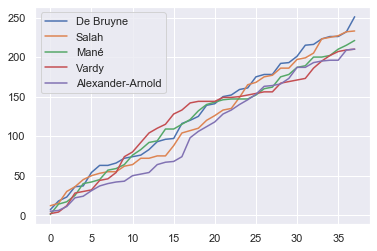

In [61]:
plt.plot(data.iloc[:,5:])
plt.gca().legend((data.columns.values))

# K-means clustering

In [62]:
from sklearn.cluster import KMeans
from sklearn import preprocessing
x = player_data[['cost_18_19', 'points_18_19']]
x_scaled = preprocessing.scale(x)
kmeans = KMeans(4)
kmeans.fit(x_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [63]:
x_copy = x.copy()
x_copy['category'] = kmeans.fit_predict(x_scaled)

Text(0.5, 1.0, 'Clusters of players')

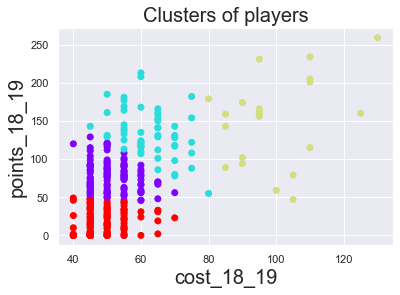

In [64]:
plt.scatter(x['cost_18_19'], x['points_18_19'], c=x_copy['category'], cmap='rainbow')
plt.xlabel('cost_18_19', fontsize=20)
plt.ylabel('points_18_19', fontsize=20)
plt.title('Clusters of players', fontsize=20)

Four clusters: <br>
Low cost, low points <br>
Low cost, high points <br>
High cost, low points <br>
High cost, high points

### Elbow method and WCSS

In [65]:
wcss = []
# 'cl_num' is a that keeps track the highest number of clusters we want to use the WCSS method for. We have it set at 10 right now, but it is completely arbitrary.
cl_num = 10
for i in range (1,cl_num):
    kmeans= KMeans(i)
    kmeans.fit(x_scaled)
    wcss_iter = kmeans.inertia_
    wcss.append(wcss_iter)
wcss

[642.0,
 320.9158589844413,
 190.1792856662764,
 142.80612046951816,
 118.045222197128,
 97.89803642126009,
 83.28435754262044,
 74.08796759457485,
 63.37880499573664]

Text(0, 0.5, 'Within-cluster Sum of Squares')

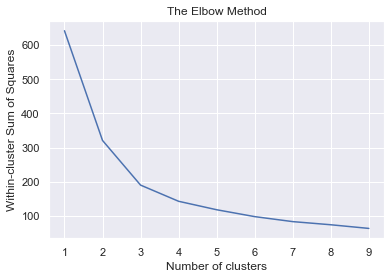

In [66]:
number_clusters = range(1,cl_num)
plt.plot(number_clusters, wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Within-cluster Sum of Squares')

## Use categories based on K-means clustering for tensorflow model

In [67]:
player_data_restrict['category'] = x_copy.loc[:,'category'].copy()
dummies = pd.get_dummies(player_data_restrict['category'], columns=[['cat_1', 'cat_2', 'cat_3', 'cat_4']], drop_first=False)
dummies.columns = ['cat_1', 'cat_2', 'cat_3', 'cat_4'] 
player_categories = pd.concat([player_data_restrict, dummies], axis=1)
player_categories.drop(['category'], axis=1, inplace=True)
player_categories.to_csv('outputs/player_categories.csv', index=False)
player_categories

,name,assists,bonus,bps,clean_sheets,creativity,end_cost,goals_conceded,goals_scored,ict_index,...,start_cost,threat,total_points,yellow_cards,cost_18_19,improve,cat_1,cat_2,cat_3,cat_4
1,Aaron_Cresswell_376,7,10,613,10,562.7,49,60,1,145.0,...,50,193.0,118,7,55,0,0,0,0,1
2,Aaron_Lennon_430,4,0,204,6,203.2,54,30,0,73.3,...,55,297.0,65,2,50,0,0,0,0,1
3,Aaron_Mooy_516,3,8,576,10,848.8,52,52,4,195.2,...,55,350.0,113,4,55,0,1,0,0,0
4,Aaron_Wan-Bissaka_122,0,0,116,2,60.0,45,10,0,26.8,...,45,2.0,15,1,40,1,1,0,0,0
5,Abdoulaye_Doucouré_368,4,16,679,9,595.8,52,63,7,199.7,...,50,537.0,136,10,60,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,Wilfred_Ndidi_176,4,4,449,9,230.7,49,45,0,117.2,...,50,299.0,78,6,50,1,1,0,0,0
316,Wilfried_Zaha_133,7,8,404,10,716.9,71,31,9,251.0,...,70,1125.0,136,5,70,1,0,1,0,0
317,Willian_Borges Da Silva_113,8,13,522,9,891.5,70,19,6,224.5,...,70,715.0,130,1,75,0,0,1,0,0
319,Will_Hughes_370,3,5,190,4,267.0,46,16,2,64.3,...,50,136.0,53,0,50,1,1,0,0,0


# Deep learning with Tensorflow
Using the player data from the 17-18 season, how accurately can you predict the cluster that a player will be in for the 18-19 season. 

In [68]:
import tensorflow as tf

In [69]:
data = pd.read_csv('outputs/player_categories.csv')

inputs = data[['assists', 'bonus', 'bps', 'clean_sheets', 'end_cost',
       'goals_conceded', 'goals_scored', 'minutes',
       'own_goals', 'penalties_missed', 'penalties_saved', 'red_cards',
       'saves', 'start_cost', 'total_points',
       'yellow_cards', 'cost_18_19', 'ict_index']]
targets = data[['cat_1', 'cat_2', 'cat_3', 'cat_4']]

scaler = StandardScaler()
scaler.fit(inputs)

inputs_scaled_all = scaler.transform(inputs)

targets_all = targets.to_numpy()

shuffled_indices = np.arange(inputs_scaled_all.shape[0])
np.random.shuffle(shuffled_indices)

shuffled_inputs = inputs_scaled_all[shuffled_indices]
shuffled_targets = targets_all[shuffled_indices]

# Count the total number of samples
samples_count = shuffled_inputs.shape[0]

# Count the samples in each subset, assuming we want 80-10-10 distribution of training, validation, and test.
train_samples_count = int(0.8 * samples_count)
validation_samples_count = int(0.1 * samples_count)

# The 'test' dataset contains all remaining data.
test_samples_count = samples_count - train_samples_count - validation_samples_count

# Create variables that record the inputs and targets for training
# In our shuffled dataset, they are the first "train_samples_count" observations
train_inputs = shuffled_inputs[:train_samples_count]
train_targets = shuffled_targets[:train_samples_count]

# Create variables that record the inputs and targets for validation.
# They are the next "validation_samples_count" observations, folllowing the "train_samples_count" we already assigned
validation_inputs = shuffled_inputs[train_samples_count:train_samples_count+validation_samples_count]
validation_targets = shuffled_targets[train_samples_count:train_samples_count+validation_samples_count]

# Create variables that record the inputs and targets for test.
# They are everything that is remaining.
test_inputs = shuffled_inputs[train_samples_count+validation_samples_count:]
test_targets = shuffled_targets[train_samples_count+validation_samples_count:]

# We balanced our dataset to be 50-50 (for targets 0 and 1), but the training, validation, and test were 
# taken from a shuffled dataset. Check if they are balanced, too. Note that each time you rerun this code, 
# you will get different values, as each time they are shuffled randomly.
# Normally you preprocess ONCE, so you need not rerun this code once it is done.
# If you rerun this whole sheet, the npzs will be overwritten with your newly preprocessed data.

# Print the number of targets that are 1s, the total number of samples, and the proportion for training, validation, and test.
print(train_samples_count)
print(validation_samples_count)
print(test_samples_count)

172
21
22


In [70]:
np.savez('outputs/player_categories_train', inputs=train_inputs, targets=train_targets)
np.savez('outputs/player_categories_validation', inputs=validation_inputs, targets=validation_targets)
np.savez('outputs/player_categories_test', inputs=test_inputs, targets=test_targets)

In [71]:
# create temporary variable npz, stores the three datasets
npz = np.load('outputs/player_categories_train.npz')

# extract inputs using keywords
# ensure all floats
train_inputs, train_targets = npz['inputs'].astype(np.float), npz['targets'].astype(np.int)
# targets must be int because of sparse_categorical_crossentropy (we want to be able to smoothly one-hot encode them)

# load validation data in temporary variable
npz = np.load('outputs/player_categories_validation.npz')
validation_inputs, validation_targets = npz['inputs'].astype(np.float), npz['targets'].astype(np.int)

# load test data in the temporary variable
npz = np.load('outputs/player_categories_test.npz')
test_inputs, test_targets = npz['inputs'].astype(np.float), npz['targets'].astype(np.int)

# Model

In [72]:
# set parameters
input_size = train_inputs.shape[1]
output_size = train_targets.shape[1]
hidden_layer_size = 50
    
# define model
model = tf.keras.Sequential([
    # tf.keras.layers.Dense is basically implementing: output = activation(dot(input, weight) + bias)
    # it takes several arguments, but the most important ones for us are the hidden_layer_size and the activation function
    tf.keras.layers.Dense(hidden_layer_size, activation='relu'), # 1st hidden layer
    tf.keras.layers.Dense(hidden_layer_size, activation='relu'), # 2nd hidden layer
    #tf.keras.layers.Dense(hidden_layer_size, activation='relu'), # 3rd hidden layer
    #tf.keras.layers.Dense(hidden_layer_size, activation='relu'), # 4th hidden layer
    # the final layer is no different, we just make sure to activate it with softmax
    tf.keras.layers.Dense(output_size, activation='softmax') # output layer
])


### Choose the optimizer and the loss function

# we define the optimizer we'd like to use, 
# the loss function, 
# and the metrics we are interested in obtaining at each iteration
# sparse for label vectors e.g. 0,1,2; not one hot encoded targets
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) 

### Training
# That's where we train the model we have built.

# set the batch size
batch_size = 100

# set a maximum number of training epochs
max_epochs = 100

# set an early stopping mechanism
# let's set patience=2, to be a bit tolerant against random validation loss increases
early_stopping = tf.keras.callbacks.EarlyStopping(patience=2)

# fit the model
# note that this time the train, validation and test data are not iterable
model.fit(train_inputs, # train inputs
          train_targets, # train targets
          batch_size=batch_size, # batch size
          epochs=max_epochs, # epochs that we will train for (assuming early stopping doesn't kick in)
          # callbacks are functions called by a task when a task is completed
          # task here is to check if val_loss is increasing
          callbacks=[early_stopping], # early stopping
          validation_data=(validation_inputs, validation_targets), # validation data
          verbose = 2 # making sure we get enough information about the training process
          )

Train on 172 samples, validate on 21 samples
Epoch 1/100
172/172 - 2s - loss: 1.4709 - accuracy: 0.4244 - val_loss: 1.4860 - val_accuracy: 0.3810
Epoch 2/100
172/172 - 0s - loss: 1.4052 - accuracy: 0.4477 - val_loss: 1.4257 - val_accuracy: 0.4286
Epoch 3/100
172/172 - 0s - loss: 1.3496 - accuracy: 0.4651 - val_loss: 1.3716 - val_accuracy: 0.4286
Epoch 4/100
172/172 - 0s - loss: 1.2994 - accuracy: 0.4767 - val_loss: 1.3224 - val_accuracy: 0.4762
Epoch 5/100
172/172 - 0s - loss: 1.2547 - accuracy: 0.4826 - val_loss: 1.2784 - val_accuracy: 0.4762
Epoch 6/100
172/172 - 0s - loss: 1.2129 - accuracy: 0.4884 - val_loss: 1.2379 - val_accuracy: 0.4762
Epoch 7/100
172/172 - 0s - loss: 1.1746 - accuracy: 0.5000 - val_loss: 1.1996 - val_accuracy: 0.5714
Epoch 8/100
172/172 - 0s - loss: 1.1408 - accuracy: 0.5291 - val_loss: 1.1635 - val_accuracy: 0.6190
Epoch 9/100
172/172 - 0s - loss: 1.1110 - accuracy: 0.5291 - val_loss: 1.1297 - val_accuracy: 0.6190
Epoch 10/100
172/172 - 0s - loss: 1.0805 - acc

## Analyse model

In [73]:
y_hat = pd.DataFrame(np.squeeze(model.predict_on_batch(train_inputs)).round().astype(int)) # problem, can't index
results = pd.concat([y_hat, pd.DataFrame(train_targets)], axis=1)
results.columns = [['prob_1', 'prob_2', 'prob_3', 'prob_4', 'cat_1', 'cat_2', 'cat_3', 'cat_4']]
results

,prob_1,prob_2,prob_3,prob_4,cat_1,cat_2,cat_3,cat_4
0,0,1,0,0,0,1,0,0
1,0,0,0,0,1,0,0,0
2,0,0,0,1,0,0,0,1
3,0,0,1,0,0,0,1,0
4,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...
167,1,0,0,0,0,1,0,0
168,1,0,0,0,1,0,0,0
169,0,1,0,0,0,1,0,0
170,0,1,0,0,0,1,0,0


In [74]:
print(np.sum(results.iloc[:,0] == results.iloc[:,4])/len(results), 
      np.sum(results.iloc[:,1] == results.iloc[:,5])/len(results), 
      np.sum(results.iloc[:,2] == results.iloc[:,6])/len(results), 
      np.sum(results.iloc[:,3] == results.iloc[:,7])/len(results)
     )

0.8430232558139535 0.9302325581395349 1.0 0.9011627906976745


## Test model

In [75]:
test_loss, test_accuracy = model.evaluate(test_inputs, test_targets)

22/22 [==============================] - 0s 227us/sample - loss: 0.9708 - accuracy: 0.6364


In [76]:
# We can apply some nice formatting if we want to
print('Test loss: {0:.2f}. Test accuracy: {1:.2f}%'.format(test_loss, test_accuracy*100.))

Test loss: 0.97. Test accuracy: 63.64%


# Thoughts for further work

Analyse the features from the random forest regression model. 

Test random forest regression model on previous seasons.

Separate players by position.

Use as much data about a player as possible e.g. if player has played in the prem for the past 3 seasons, represent this in the model somehow. The assumption behind this being that if a player has more prem experience, their performance is likely to be more predictable, as opposed to a player who has only played one season. 

If this proves effective, could then look at obtaining data for players who have just joined the prem (new signings), and attempt to predict how well they will adapt to the prem. 